In [56]:
import numpy as np
import cv2
from open3d import *
from matplotlib import pyplot as plt
import random

In [157]:
work_dir = '/home/shubham/jobs/brain/'
suffix = '2'

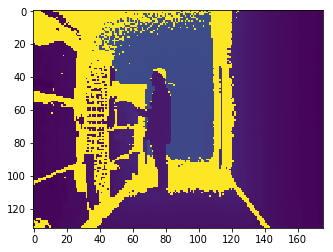

In [158]:

dmap = np.loadtxt('human_corridor_'  +suffix + '.txt')
plt.imshow(dmap)

In [159]:
print("min max : ", np.min(dmap),np.max(dmap))
print(dmap.shape)
dmap = dmap.astype(np.float32)

('min max : ', 1.218000054359436, 32.766998291015625)
(132, 176)


In [160]:
r = 1.3
dr = 3

dmap[(dmap <= r) | (dmap >= r+dr)] =0

In [161]:
pt1 = [H//2,5,dmap[H//2,5]]
pt2 = [H//2,W-5,dmap[H//2,W-5]]
f = 170*pt1[2]/(1.5)

In [177]:
pt2[2]

dpcl = create_point_cloud_from_depth_image(source_depth,intr)
write_point_cloud()

In [163]:
# K = K_out=K_out.squeeze()
H,W = dmap.shape

# (width: int, height: int, fx: float, fy: float, cx: float, cy: float)
fx,fy,cx,cy = W,W,W//2,H//2
# width,height,_ = w1.shape
intr = PinholeCameraIntrinsic(W,H,fx,fy,cx,cy)
source_color = Image(128*np.ones([H,W,3],dtype=np.int8))
source_depth = Image(dmap.squeeze())

source_rgbd_image = create_rgbd_image_from_color_and_depth(source_color, source_depth)
source_pcd = create_point_cloud_from_rgbd_image(source_rgbd_image, intr)
#
# write_point_cloud(self.op_dir + '/depth_map_cloud' + postfix + ".ply", source_pcd)

In [164]:
write_point_cloud(work_dir + '/depth_map_cloud' + suffix + ".ply", source_pcd)

True

In [165]:
pts = np.asarray(source_pcd.points)

In [166]:
pts.shape
scale = abs(np.max(pts[:,0]) - np.min(pts[:,0])) / 1.5
pts = pts/scale
print("x min max:",np.min(pts[:,0]),np.max(pts[:,0]) )
print("z min max",np.min(pts[:,2]),np.max(pts[:,2]) )
pcd = PointCloud()
pcd.points = Vector3dVector(pts)
write_point_cloud(work_dir + 'depth_map_cloud_' + suffix + ".ply", pcd)

('x min max:', -0.8613700918981675, 0.6386299081018326)
('z min max', 1.009640295467927, 3.333673941878841)


True

In [170]:
orientations = []
def gen_plane(pts):
#     pdb.set_trace()
    A = np.ones_like(pts)
#     pdb.set_trace()
    A[:,0:2] = pts[:,0:2]
    B = pts[:,2]
#     b = np.matrix(B).T
#     A = np.matrix(A)
#     if(A.shape[0]==3):
    fit = np.linalg.solve(A,B)
#     else:
#         fit = np.linalg.lstsq(A,B)[0]
#     fit = (A.T * A).I * A.T * B
    return fit

def get_plane_inliers(pts,plane,thresh=0.1):
    plane = plane.reshape(3,1)
    A = np.ones_like(pts)
    A[:,0:2] = pts[:,0:2]
    B = pts[:,2]
#     pdb.set_trace()
    dts = abs(B.reshape(-1,1) - A.dot(plane))/ np.sqrt(plane[0]**2 + plane[1]**2 +1)
    
#     errors = B.reshape(-1,1) - A.dot(plane)
    return np.where(dts.squeeze() < thresh)[0]

import pdb
plane_count = 3
planes = []
cur_pt_set = pts.copy()

ransac_iters = 1000
for i in range(plane_count):
    if(cur_pt_set.shape[0]<4):
        print("not enough points, breaking \n")
        break
    best,best_inliers,max_inliers  = None,None,0
    for j in range(ransac_iters):
        rng = cur_pt_set.shape[0]
        
        inds = random.sample(range(0, rng), 3)
        try:
            plane = gen_plane(cur_pt_set[inds])
        except:
            continue
        inliers  = get_plane_inliers(cur_pt_set,plane)
        if(len(inliers)>max_inliers):
        
            best = plane
            max_inliers = len(inliers)
            print("new max : ",max_inliers)
            best_inliers = inliers
            
    ##end of ransac loop
    print("max inliers:",max_inliers)
#     pdb.set_trace()
#     svd_plane = gen_plane(cur_pt_set[best_inliers])
    svd_plane = best
    
#     inliers = get_plane_inliers(cur_pt_set,svd_plane)
    print("new refitted inliers: ",len(best_inliers))
    wall_pts = cur_pt_set[best_inliers]
    if(np.median(wall_pts[:,0]) > 0):
        orientations.append('right')
    else:
        orientations.append('left')
            
    pcd = PointCloud()
    pcd.points = Vector3dVector(wall_pts)
    write_point_cloud(work_dir + 'wall_' + str(i) + ".ply", pcd)
    cur_pt_set =np.delete(cur_pt_set,best_inliers,axis=0)
#     pdb.set_trace()
#     cur_pt_set.remove(inliers)
    planes.append(svd_plane)

#####
# 3 planes, find two with normals perpendicular to z (dot product 0)

human_pts = cur_pt_set ##
pcd = PointCloud()
pcd.points = Vector3dVector(human_pts)
write_point_cloud(work_dir + 'human_' + suffix + ".ply", pcd)
        
    
    

('new max : ', 1892)
('new max : ', 2015)
('new max : ', 2565)
('new max : ', 6317)
('new max : ', 7016)
('new max : ', 7073)
('new max : ', 7109)
('new max : ', 7188)
('max inliers:', 7188)
('new refitted inliers: ', 7188)
('new max : ', 951)
('new max : ', 2644)
('new max : ', 3759)
('new max : ', 3784)
('new max : ', 3918)
('new max : ', 3927)
('new max : ', 3937)
('new max : ', 3956)
('max inliers:', 3956)
('new refitted inliers: ', 3956)
('new max : ', 1008)
('new max : ', 1019)
('new max : ', 1074)
('new max : ', 1324)
('new max : ', 1328)
('new max : ', 1332)
('new max : ', 1341)
('new max : ', 1351)
('new max : ', 1353)
('new max : ', 1354)
('max inliers:', 1354)
('new refitted inliers: ', 1354)


True

In [171]:
planes
norms = -1*np.ones_like(planes)
for i in range(norms.shape[0]):
    norms[i,0:2] = planes[i][0:2]
    norms[i,:] = norms[i,:]/np.linalg.norm(norms[i,:])
# norms[:,0:2] = planes[:,0:2]
x = np.array([1, 0, 0])
dots = []
for i in range(norms.shape[0]):
    print(abs(np.dot(norms[i],x)))
    dots.append(abs(np.dot(norms[i],x)))
sorted_planes = np.argsort(dots)

0.9967619191462914
0.9919064948341886
0.0677269986916243


In [173]:
sorted_planes
walls = []
wall_ors =[]
for i in sorted_planes[1:]:
    walls.append(planes[i])
    wall_ors.append(orientations[i])
# walls = planes[sorted_planes[1:]]
walls

[array([129.44061126, -16.53903724,  83.23743675]),
 array([112.7478677 ,   9.04030391, -64.94310248])]

In [175]:
wall_ors
sorted_planes

array([2, 1, 0])

In [176]:
# tp = np.array([0,0,planes[0][2]])
max_clear = 0
for i in range(2):
    pts=human_pts
    pl = walls[i]
    A = np.ones_like(pts)
    A[:,0:2] = pts[:,0:2]
    B = pts[:,2]
    #     pdb.set_trace()
    dts = abs(B.reshape(-1,1) - A.dot(pl))/ np.sqrt(pl[0]**2 + pl[1]**2 +1)
    med_dts = np.median(dts)
    print("median wall to human dist:", np.median(dts))
    if(max_clear<med_dts):
        answer = [wall_ors[i], med_dts]
        max_clear = med_dts
print(answer)

('median wall to human dist:', 0.41325890581188146)
('median wall to human dist:', 0.7919740971024922)
['right', 0.7919740971024922]


In [120]:
tp = np.array([0,0,planes[0][2]])
pl = planes[1]
A = np.ones_like(tp)
A[0:2] = tp[0:2]
B = tp[2]
#     pdb.set_trace()
dts = abs(B.reshape(-1,1) - A.dot(pl))/ np.sqrt(pl[0]**2 + pl[1]**2 +1)
print(dts.shape)
print(np.median(dts))

(1, 1)
0.7250789547565589


In [65]:
N_POINTS = 10
TARGET_X_SLOPE = 2
TARGET_y_SLOPE = 3
TARGET_OFFSET  = 5
EXTENTS = 5
NOISE = 1

# create random data
xs = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
ys = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
zs = []
for i in range(N_POINTS):
    zs.append(xs[i]*TARGET_X_SLOPE + \
              ys[i]*TARGET_y_SLOPE + \
              TARGET_OFFSET + np.random.normal(scale=NOISE))

# plot raw data
# plt.figure()
# ax = plt.subplot(111, projection='3d')
# ax.scatter(xs, ys, zs, color='b')

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

In [70]:
fit

matrix([[2.2155031 ],
        [3.16052372],
        [4.72444374]])

In [73]:
A*fit.squeeze()

ValueError: shapes (10,3) and (1,3) not aligned: 3 (dim 1) != 1 (dim 0)

In [74]:
errors.shape

(10, 1)